# Ứng dụng các thuật toán luật kết hợp để phân tích giỏ hàng đăng ký dịch vụ Internet của khách hàng
---

#### I. Khai báo dữ liệu và các thư viện cần thiết
#### II. Triển khai các thuật toán
#####    1. Hàm xây dựng thuật toán Apriori
#####    2. Hàm xây dựng thuật toán FP - Growth
#####    3. Kết quả thuật toán

---

# I. Khai báo dữ liệu và các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
df = pd.read_excel('Telco_Churn_dataset.xlsx')

# II. Triển khai các thuật toán

## 1. Hàm xây dựng thuật toán Apriori

In [3]:
def analyze_services_apriori():
    # Loại bỏ các dòng không có internet service
    df_internet = df[df['InternetService'] != 'No']
    
    # Chọn các cột dịch vụ
    services = ['InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
    
    # Tạo bản sao dữ liệu dịch vụ
    service_data = df_internet[services].copy()
    
    # One-hot encoding cho InternetService
    service_data_encoded = pd.get_dummies(service_data['InternetService'], prefix='InternetService')
    
    # Chuyển các cột còn lại thành boolean
    for col in services[1:]:
        service_data_encoded[col] = service_data[col].map({'Yes': True, 'No': False})
        
    # Áp dụng Apriori để tìm tập hợp thường xuyên
    frequent_itemsets = apriori(service_data_encoded, 
                                min_support=0.1, 
                                use_colnames=True)

    # Tạo luật kết hợp với ngưỡng confidence là 0.7
    rules = association_rules(frequent_itemsets, 
                              metric="confidence", 
                              min_threshold=0.7, 
                              num_itemsets=1000)
    
    # Sắp xếp theo lift giảm dần
    rules_yes = rules.sort_values('lift', ascending=False)
    
    display(frequent_itemsets.sort_values('support', ascending = False))
    display(service_data_encoded)
    
    return rules_yes


## 2. Hàm xây dựng thuật toán FP-Growth

In [4]:
def visualize_fp_tree(frequent_itemsets):
    # Hàm xây dựng và trực quan hóa FP-Tree
    def build_fp_tree(transactions):
        tree = {'name': 'NULL', 'count': 0, 'children': {}, 'parent': None}
        header_table = defaultdict(list)

        for transaction in transactions:
            current_node = tree
            for item in transaction:
                if item not in current_node['children']:
                    new_node = {'name': item, 'count': 1, 'children': {}, 'parent': current_node}
                    current_node['children'][item] = new_node
                    header_table[item].append(new_node)
                else:
                    current_node['children'][item]['count'] += 1
                current_node = current_node['children'][item]

        return tree, header_table

    def extract_transactions(dataframe):
        transactions = []
        for _, row in dataframe.iterrows():
            items = row[row > 0].index.tolist()
            transactions.append(items)
        return transactions

    def draw_fp_tree(tree):
        graph = nx.DiGraph()

        def add_edges(node):
            for child in node['children'].values():
                graph.add_node(child['name'], label=f"{child['name']} ({child['count']})")
                graph.add_edge(node['name'], child['name'])
                add_edges(child)

        graph.add_node(tree['name'], label=f"{tree['name']} ({tree['count']})")
        add_edges(tree)

        pos = nx.spring_layout(graph)
        labels = nx.get_node_attributes(graph, 'label')
        plt.figure(figsize=(12, 8))
        nx.draw(graph, pos, labels=labels, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
        plt.title("FP-Tree Visualization")
        plt.show()

    # Xây dựng FP-Tree từ các tập giao dịch
    transactions = extract_transactions(frequent_itemsets)
    tree, _ = build_fp_tree(transactions)

    # Vẽ FP-Tree
    draw_fp_tree(tree)


In [5]:
def analyze_services_fp_growth():
    # Loại bỏ các dòng không có internet service
    df_internet = df[df['InternetService'] != 'No']
    
    # Chọn các cột dịch vụ
    services = ['InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
    
    # Tạo bản sao dữ liệu dịch vụ
    service_data = df_internet[services].copy()
    
    # One-hot encoding cho InternetService
    service_data_encoded = pd.get_dummies(service_data['InternetService'], prefix='InternetService')
    
    # Chuyển các cột còn lại thành boolean
    for col in services[1:]:
        service_data_encoded[col] = service_data[col].map({'Yes': True, 'No': False})

    # Áp dụng FP-Growth để tìm tập hợp thường xuyên
    frequent_itemsets = fpgrowth(service_data_encoded, 
                                 min_support=0.1, 
                                 use_colnames=True)

    # Tạo luật kết hợp với ngưỡng confidence là 0.7
    rules = association_rules(frequent_itemsets, 
                              metric="confidence", 
                              min_threshold=0.7, 
                              num_itemsets=1000)
    
    # Trực quan hóa FP-Tree
    visualize_fp_tree(service_data_encoded)
    
    # Sắp xếp theo lift giảm dần
    rules_yes = rules.sort_values('lift', ascending=False)
    
    
    return rules_yes

In [8]:
def display_top_20_rules(rules):
    # Sắp xếp các luật theo 'lift' giảm dần và lấy 10 luật đầu tiên
    top_20_rules = rules.sort_values('lift', ascending=False).head(20)
    
    # Hiển thị các luật top 10 với các thông tin: antecedents, consequents, lift, confidence
    top_20_rules_display = top_20_rules[['antecedents', 'consequents', 'lift', 'confidence', 'support']]
    
    return top_20_rules_display


## 3. Kết quả thuật toán

### a. Kết quả cơ sở dữ liệu giao dịch và tập phổ biến

In [6]:
# Thực thi phân tích
service_rules_apriori = analyze_services_apriori()

,support,itemsets
1,0.561175,(InternetService_Fiber optic)
7,0.495197,(StreamingMovies)
6,0.490665,(StreamingTV)
3,0.440276,(OnlineBackup)
4,0.439007,(DeviceProtection)
...,...,...
80,0.106217,"(StreamingTV, TechSupport, StreamingMovies, On..."
78,0.104948,"(OnlineSecurity, DeviceProtection, StreamingMo..."
38,0.102955,"(InternetService_DSL, DeviceProtection, Online..."
74,0.102048,"(StreamingTV, InternetService_Fiber optic, Dev..."


,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,True,False,False,True,False,False,False,False
1,True,False,True,False,True,False,False,False
2,True,False,True,True,False,False,False,False
3,True,False,True,False,True,True,False,False
4,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
7038,True,False,True,False,True,True,True,True
7039,False,True,False,True,True,False,True,True
7040,True,False,True,False,False,False,False,False
7041,False,True,False,False,False,False,False,False


### b. Kết quả trực quan cây FP - Tree

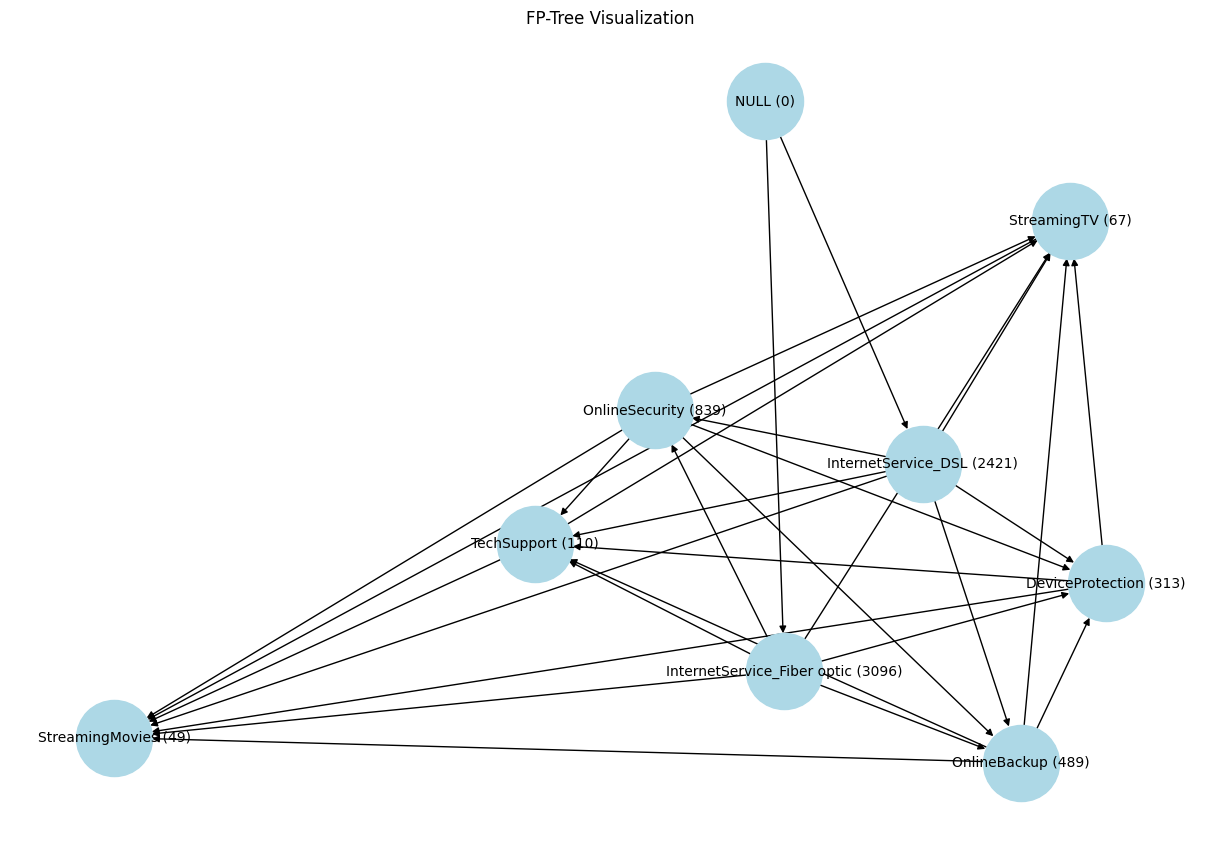

In [7]:
service_rules_fp_growth = analyze_services_fp_growth()

In [9]:
pd.set_option('display.max_colwidth', 100)

### c. Hiển thị top 20 luật tốt nhất của hai thuật toán

In [11]:
display_top_20_rules(service_rules_apriori)

,antecedents,consequents,lift,confidence,support
26,"(OnlineSecurity, StreamingMovies, StreamingTV)",(DeviceProtection),1.701789,0.747097,0.104948
34,"(TechSupport, StreamingMovies, StreamingTV)",(DeviceProtection),1.701163,0.746822,0.127787
22,"(InternetService_Fiber optic, DeviceProtection, StreamingMovies)",(StreamingTV),1.688188,0.828335,0.145188
33,"(TechSupport, DeviceProtection, StreamingTV)",(StreamingMovies),1.686821,0.835308,0.127787
23,"(InternetService_Fiber optic, DeviceProtection, StreamingTV)",(StreamingMovies),1.676206,0.830052,0.145188
32,"(TechSupport, DeviceProtection, StreamingMovies)",(StreamingTV),1.661069,0.815029,0.127787
29,"(DeviceProtection, StreamingMovies, OnlineBackup)",(StreamingTV),1.650486,0.809836,0.134312
27,"(DeviceProtection, OnlineBackup, StreamingTV)",(StreamingMovies),1.644368,0.814286,0.134312
25,"(OnlineSecurity, DeviceProtection, StreamingTV)",(StreamingMovies),1.635290,0.809790,0.104948
31,"(TechSupport, StreamingMovies, OnlineBackup)",(StreamingTV),1.622686,0.796196,0.106217


In [12]:
display_top_20_rules(service_rules_fp_growth)

,antecedents,consequents,lift,confidence,support
19,"(OnlineSecurity, StreamingMovies, StreamingTV)",(DeviceProtection),1.701789,0.747097,0.104948
24,"(TechSupport, StreamingMovies, StreamingTV)",(DeviceProtection),1.701163,0.746822,0.127787
8,"(InternetService_Fiber optic, DeviceProtection, StreamingMovies)",(StreamingTV),1.688188,0.828335,0.145188
23,"(TechSupport, DeviceProtection, StreamingTV)",(StreamingMovies),1.686821,0.835308,0.127787
9,"(InternetService_Fiber optic, DeviceProtection, StreamingTV)",(StreamingMovies),1.676206,0.830052,0.145188
22,"(TechSupport, DeviceProtection, StreamingMovies)",(StreamingTV),1.661069,0.815029,0.127787
12,"(DeviceProtection, StreamingMovies, OnlineBackup)",(StreamingTV),1.650486,0.809836,0.134312
10,"(DeviceProtection, OnlineBackup, StreamingTV)",(StreamingMovies),1.644368,0.814286,0.134312
18,"(OnlineSecurity, DeviceProtection, StreamingTV)",(StreamingMovies),1.635290,0.809790,0.104948
30,"(TechSupport, StreamingMovies, OnlineBackup)",(StreamingTV),1.622686,0.796196,0.106217
